<center>
    <span><h4><b>
        CLIMBING PROFILE PREDICTION</b></h4></span>
        <h5><b>
        Data preprocessing & k-means clusterization</b></h5>
 </center>
        <p> </p>
        <p> </p>
        <center><span style="color:blue; font-family:Georgia;  font-size:1em;">
        Alekandra Samol</span></center>
        <center>Data mining - Master on Computer Science</center>
        

## **Database information**

Data were dowloaded from **8a.nu web application**. [8a.nu](https://www.8a.nu/) it's online, **international climbing ranking** where climbers from all over the world add information which climbing routes they have done, in which region they are, and they also can add comments. 

Based on routes difficulty, they get proper scores which are cumulated and on that basis they get a suitable place in the ranking.

**The main goal** of this project is to create application which will give proposition of routes and regions which fit to your climbing profile the best.


**In this part** will be presented:


1.   Data collecting
2.   Data Cleaning & analysis
3.   K - means clusterization model



## **1.Data collecting**



-> [COLLECTING DATA - NOTEBOOK](https://colab.research.google.com/drive/1C_Hu4HCYy_MhjyPlob0RYWNBMy4-n1kg?authuser=2#scrollTo=lvrbYQyXu2vy)


## **2.Data cleaning & analysis**

####Loading all needed tools and libraries.

In [2]:
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import io 
import glob 
import numpy as np

Mounted at /content/drive


In [4]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
!tar xf spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.1-bin-hadoop2.7"

In [6]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
sc = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('8a_kmeans')


In [40]:
from pyspark.ml.clustering import KMeans

In [8]:
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.clustering import KMeansModel
import pandas as pd
import math
import random
import sys

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [9]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

#### Climbing grades


In sport climbing, a special scale is used which determines the difficulty of the route. In next step we are transforming that ordinal scale into numeric in order to further analysis.
<center><img src="https://sportrock.com/wp-content/uploads/2020/01/YDS2020-01.png"></center>


In [ ]:
# dictionary to transform climbing grades into numeric scale:
gradeDict = {'3a': 3.0, '3b': 3.0, '3c': 3.0, '4a': 4.0, '4b': 4.0, '4c': 4.0,  "4":4.0, "5a":5.0, "5a+":5.05, "5b":5.1, "5b+":5.15, "5c":5.2, "5c+":5.25, "6a":6.0, "6a+":6.05,"6b":6.1, "6b+":6.15, "6c":6.2,"6c+":6.25, "7a":7.0, "7a+":7.05, "7b":7.1, "7b+":7.15, "7c":7.2, "7c+":7.25, "8a":8.0, "8a+":8.05, "8b": 8.1, "8b+":8.15, "8c":8.2, "8c+":8.25, "9a":9.0, "9a+":9.05, "9b":9.1, "9b+": 9.15, "9c":9.2}


In the next stages we will use the data frame prepared at the stage of data preparation.

In [ ]:
# Loading dataframe prepered in 1 st step
df = pd.read_csv('/content/drive/MyDrive/DM_CLIMBING/all_joined.csv')

In [ ]:
df = df.drop(['Unnamed: 0.1', 'comment'], axis = 1)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345470 entries, 0 to 345469
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   345470 non-null  int64  
 1   type         345470 non-null  object 
 2   route        345470 non-null  object 
 3   crag         345470 non-null  object 
 4   sector       219008 non-null  object 
 5   date         345470 non-null  object 
 6   commentRich  184589 non-null  object 
 7   quality      191666 non-null  object 
 8   style        345470 non-null  object 
 9   country      345470 non-null  object 
 10  region       166519 non-null  object 
 11  grade        345470 non-null  float64
dtypes: float64(1), int64(1), object(10)
memory usage: 31.6+ MB


Merged dataframe has:


*   345 470 rows
*   12 columns
*   columns names:  



Drop rows where comment and quality are null - no option to predict

In [ ]:
# move it to notebook with translated info and model to predict quality based on comment
#df = df.drop(df[(df['commentRich'].isnull())& (df['quality'].isnull())].index)

In [ ]:
#df = df.drop(['Unnamed: 0', 'comment', 'date'], axis = 1)

Creating new data frame with columns which are usefull for further analysis.

In [185]:
cragGrade = df[['crag', 'grade','style', 'quality','country', 'sector', 'region']].sort_values(by='crag')

All columns have been changed to lower case in order to standardize data

In [186]:

cragGrade["crag"] = cragGrade["crag"].str.lower()
cragGrade["style"] = cragGrade["style"].str.lower()
cragGrade["country"] = cragGrade["country"].str.lower()
cragGrade["region"] = cragGrade["region"].str.lower()
cragGrade["sector"] = cragGrade["sector"].str.lower()

In [187]:
cragGrade.country

334744          reunion
335511          reunion
77017     united states
71581     united states
76992     united states
              ...      
76094            poland
76424            poland
76157            poland
100726           turkey
100818           turkey
Name: country, Length: 345470, dtype: object

#### Calculation:  OS/RP ratio

OS and RP are styles of climbing. OS is more difficult because it means that route was done by climber at first attempt, while RP means that the climber had known this route and has already made some attempts on it.

Analysis OS/RP ratio for each sector we can make conclusions about routes difficulties.



> If that ratio is high - the region is relatively easy and moves on route are quite obvious (e.g. you can clearly see all the holds from the ground)



In [189]:
cragGrade['OS'] = cragGrade['style'].mask(cragGrade['style'].ne('onsight'))
cragGrade['RP'] = cragGrade['style'].mask(cragGrade['style'].ne('redpoint'))

In [ ]:
cragGrade['OS'].loc[ cragGrade['OS'] == "onsight"] = 1

In [ ]:
cragGrade['RP'].loc[ cragGrade['RP'] == "redpoint"] = 1

Grouping by country to perform OS/RP ratio calculations

In [196]:
cragGrade = cragGrade.groupby('country').agg({'OS':'count', 'RP':'count','grade':'mean'})

Calculate OS/RP ratio:

In [197]:
cragGrade['OS/RP'] = cragGrade['OS']/cragGrade['RP']

In [198]:
cragGrade['OS/RP'] = cragGrade['OS/RP'].fillna(0)

In [199]:
cragGrade['OS/RP'] = cragGrade['OS/RP'].round(3)
cragGrade['grade'] = cragGrade['grade'].round(3)

In [200]:
cragGrade.sort_values(by='OS/RP', ascending= False)

,OS,RP,grade,OS/RP
country,,,,
japan,4,0,7.245,inf
philippines,4,0,7.075,inf
malta,2,0,7.100,inf
jordan,76,8,5.940,9.5
netherlands,8,2,5.890,4.0
...,...,...,...,...
lebanon,0,2,7.000,0.0
liechtenstein,0,2,7.050,0.0
andorra,0,6,7.350,0.0


After ratio calculation we got in some cases inf when number of RP = 0

In next step we are changing all inf to max OS/RP value from dataframe (it means that all routes where climbed in OS style)


In [201]:
#change inf to highest ratio value from dataframe
cragGrade = cragGrade.replace([np.inf, -np.inf], 9.5)

In [202]:
# NORMALIZATION of OS/RP ratio to get values from 0 to 1

from sklearn import preprocessing
x = cragGrade[['OS/RP']].values.astype(float)
# Creating minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
cragGrade['OS/RP'] = x_scaled

In [203]:
cragGrade

,OS,RP,grade,OS/RP
country,,,,
albania,0,4,8.250,0.000000
andorra,0,6,7.350,0.000000
angola,0,8,7.225,0.000000
argentina,90,168,7.378,0.056421
australia,228,664,7.247,0.036105
...,...,...,...,...
turkey,3282,4546,7.112,0.076000
ukraine,128,270,6.719,0.049895
united kingdom,390,754,7.165,0.054421


In [205]:
cragGrade['country'] = cragGrade.index

In [206]:
sorted_country = cragGrade.sort_values(by='OS/RP',  ascending=False)

In [224]:
sorted_country.to_csv('/content/drive/MyDrive/DM_CLIMBING/os_rp_country.csv')

#### Analysis:  OS/RP ration - country 

In [208]:
best_10_countries = sorted_country.head(15)
best_10_countries

,OS,RP,grade,OS/RP,country
country,,,,,
japan,4,0,7.245,1.000000,japan
philippines,4,0,7.075,1.000000,philippines
jordan,76,8,5.940,1.000000,jordan
malta,2,0,7.100,1.000000,malta
netherlands,8,2,5.890,0.421053,netherlands
morocco,176,84,7.122,0.220526,morocco
greece,7745,3955,6.916,0.206105,greece
oman,6,4,6.670,0.157895,oman
romania,100,76,6.407,0.138526,romania


In [211]:
sorted_country = cragGrade.sort_values(by=['OS/RP', 'grade',],  ascending=False)
best_10_countries = sorted_country.head(15)
best_10_countries

,OS,RP,grade,OS/RP,country
country,,,,,
japan,4,0,7.245,1.000000,japan
malta,2,0,7.100,1.000000,malta
philippines,4,0,7.075,1.000000,philippines
jordan,76,8,5.940,1.000000,jordan
netherlands,8,2,5.890,0.421053,netherlands
morocco,176,84,7.122,0.220526,morocco
greece,7745,3955,6.916,0.206105,greece
oman,6,4,6.670,0.157895,oman
romania,100,76,6.407,0.138526,romania


In [222]:
best_10_countries[best_10_countries['RP']>100]

,OS,RP,grade,OS/RP,country
country,,,,,
greece,7745,3955,6.916,0.206105,greece
croatia,2607,2213,6.535,0.124000,croatia
thailand,808,724,6.867,0.117474,thailand
laos,284,274,6.903,0.109053,laos
south africa,320,318,7.383,0.105895,south africa


Japan, Malta, Philippines are in the first three places. 
However, due to the relatively small number of climbs, we can say that the most favorable in terms of the OS / RP ratio are:

1.   Jordan
2.   Morocco
3.   Greece
4.   Romania
5.   Croatia 



We also have to take into account the difficulty of organizing a trip to a given country and the related costs. Trips to Maroco and Jordan are quite difficult to organize, that's why it is often chosed only by people who have specific climbing projects in a given region, and thus who are more advanced in climbing.

Therefore, the easiest regions, i.e. the most favorable in terms of OS / RP ratio and where number of RP climbs is > 100 (what means that climbing there is easy to organise) are:


1.   Greece
2.   Croatia
3.   Thailand



To analyse which countries have the lowest OS/RP ratio, we chose only those with the number of climbs greater than 100.

In [218]:
worst_countries = sorted_country.tail(30)
worst_countries[worst_countries['RP']>100]

,OS,RP,grade,OS/RP,country
country,,,,,
switzerland,1746,3651,7.426,0.050316,switzerland
ukraine,128,270,6.719,0.049895,ukraine
unknown,460,1026,7.123,0.047158,unknown
slovenia,1474,3295,7.357,0.047053,slovenia
canada,544,1272,7.160,0.045053,canada
norway,1332,3342,6.967,0.042000,norway
macedonia,58,152,6.292,0.040211,macedonia
austria,2384,6344,7.214,0.039579,austria
australia,228,664,7.247,0.036105,australia


As 5 most difficult places to climb based on OS/RP ratio are:


1.   New Zealand
2.   Russia
3.   Mexico
4.   Belgium
5.   Australia



REWRITE FROM HERE:

In [ ]:
## remove duplicates, Nan values, 
dfComparison = dfComparison.drop_duplicates()
dfComparison = dfComparison.dropna()
regions = dfComparison['Region']
regions_uni = regions.unique()
regions_dict ={}

## change regions to numeric values and save codes for regions in csv file
for region_nbr in range(0,len(regions_uni)):
  regions_dict[regions_uni[region_nbr]] = region_nbr
dfComparison  = dfComparison.replace({'Region': regions_dict})


import csv
w = csv.writer(open("regions_dict.csv", "w"))
for key, val in regions_dict.items():
    w.writerow([key, val])


## normalize data to standardize features
dfComparison_norm = ((dfComparison-dfComparison.min())/(dfComparison.max()-dfComparison.min()))*10


In [ ]:
dfComparison_norm.index.name = "ID"
dfComparison_norm['ID'] = dfComparison_norm.index


## **3.K - means clusterization model**


#### Loading dataframe with inforamtion about all users:

In [57]:
df_users = pd.read_csv('/content/drive/MyDrive/DM_CLIMBING/all_users_nonnorm.csv', encoding='latin-1')

In [59]:
df_users = df_users.drop('Unnamed: 0', axis=1)

In [60]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Years      265 non-null    int64  
 1   MAX        265 non-null    float64
 2   RoutesNbr  265 non-null    int64  
 3   OS         265 non-null    float64
 4   Flash      265 non-null    float64
 5   RP         265 non-null    float64
 6   Region     265 non-null    object 
 7   <6a        265 non-null    int64  
 8   6a-6c+     265 non-null    int64  
 9   7a-7c+     265 non-null    int64  
 10  =>8a       265 non-null    int64  
 11  Grade      265 non-null    float64
dtypes: float64(5), int64(6), object(1)
memory usage: 25.0+ KB


In [61]:
df_users['ID'] = df_users.index

In [62]:
df_users = df_users.round(3)

Data frame with users contains:


*   265 users (rows)
*   12 columns



#### Change region to numeric values

In [63]:
## remove duplicates, Nan values, 
df_users = df_users.drop_duplicates()
df_users = df_users.dropna()
regions = df_users['Region']
regions_uni = regions.unique()
regions_dict ={}

In [ ]:
regions_dict

In [64]:
## change regions to numeric values and save codes for regions in csv file
for region_nbr in range(0,len(regions_uni)):
  regions_dict[regions_uni[region_nbr]] = region_nbr
df_users  = df_users.replace({'Region': regions_dict})

In [65]:
import csv
w = csv.writer(open("regions_dict.csv", "w"))
for key, val in regions_dict.items():
    w.writerow([key, val])

In [67]:
df_users.to_csv('/content/drive/MyDrive/DM_CLIMBING/all_before_norm.csv')

##### Normalization

In [69]:
# NORMALIZATION of dataframe to get values from 0 to 1

from sklearn import preprocessing
x = df_users.values.astype(float)
# Creating minimum and maximum processor object
min_max_scaler = preprocessing.MinMaxScaler()

# Create an object to transform the data to fit minmax processor
x_scaled = min_max_scaler.fit_transform(x)

# Run the normalizer on the dataframe
df_users = x_scaled

In [73]:
df_users = pd.DataFrame(df_users)

In [86]:
df_users

,Years,MAX,RoutesNbr,OS,Flash,RP,Region,<6a,6a-6c+,7a-7c+,=>8a,Grade,ID
0,0.181818,0.738095,0.218128,0.304,0.274,0.423,0.000000,0.154054,0.295956,0.134561,0.007888,0.525545,0.000000
1,0.151515,0.714286,0.157560,0.417,0.123,0.460,0.000000,0.229730,0.284926,0.062323,0.000607,0.462617,0.003788
2,0.151515,0.726190,0.127065,0.234,0.126,0.640,0.009615,0.000000,0.011029,0.135033,0.005461,0.659813,0.007576
3,0.272727,0.714286,0.094452,0.184,0.285,0.502,0.009615,0.051351,0.132353,0.061851,0.001214,0.506542,0.011364
4,0.121212,0.952381,0.067344,0.227,0.239,0.534,0.019231,0.005405,0.011029,0.045798,0.033374,0.745171,0.015152
...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,0.212121,0.726190,0.102499,0.175,0.059,0.766,0.894231,0.045946,0.115809,0.074127,0.003641,0.581308,0.984848
261,0.424242,0.726190,0.228717,0.284,0.098,0.618,0.836538,0.043243,0.007353,0.235127,0.013956,0.645171,0.988636
262,0.242424,0.714286,0.216010,0.185,0.219,0.596,1.000000,0.064865,0.193015,0.179887,0.000607,0.545171,0.992424
263,0.545455,0.726190,0.404913,0.438,0.092,0.387,0.836538,0.018919,0.538603,0.295562,0.018811,0.535202,0.996212


In [85]:
df_users = df_users.rename(columns={0:'Years', 'Years':'MAX', 2:'RoutesNbr',3: "OS", 4:"Flash",5: "RP", 6:"Region",7:"<6a" , 8:"6a-6c+",9: "7a-7c+",10: "=>8a", 11:"Grade", 12:'ID'})

In [87]:
## convert Pandas dataFrame to spark dataFrame
allData = sc.createDataFrame(df_users)
features_names = list(df_users.columns[:-1])
features_names

['Years',
 'MAX',
 'RoutesNbr',
 'OS',
 'Flash',
 'RP',
 'Region',
 '<6a',
 '6a-6c+',
 '7a-7c+',
 '=>8a',
 'Grade']

In [88]:
allData.show()

+--------------------+------------------+--------------------+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
|               Years|               MAX|           RoutesNbr|   OS|Flash|   RP|              Region|                 <6a|              6a-6c+|              7a-7c+|                =>8a|              Grade|                  ID|
+--------------------+------------------+--------------------+-----+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+
| 0.18181818181818182|0.7380952380952381| 0.21812791190173653|0.304|0.274|0.423|                 0.0| 0.15405405405405406|  0.2959558823529412| 0.13456090651558075|0.007888349514563107| 0.5255451713395636|                 0.0|
| 0.15151515151515152|0.7142857142857144| 0.15756035578144853|0.417|0.123| 0.46|            

#### Preparation of a list of features

In [89]:
## Change 0 to 0.01 because in other way problem with creating vector with features ocurs
allData = allData.withColumn("Years", F.when(F.col("Years")==0, 0.01).otherwise(F.col("Years")))
allData = allData.withColumn("MAX", F.when(F.col("MAX")==0, 0.01).otherwise(F.col("MAX")))
allData = allData.withColumn("RoutesNbr", F.when(F.col("RoutesNbr")==0, 0.01).otherwise(F.col("RoutesNbr")))
allData = allData.withColumn("RP", F.when(F.col("RP")==0, 0.01).otherwise(F.col("RP")))
allData = allData.withColumn("Grade", F.when(F.col("Grade")==0, 0.01).otherwise(F.col("Grade")))

In [90]:
## change all values to float - for each of features columns
for col in allData.columns:
    if col in features_names:
        allData = allData.withColumn(col,allData[col].cast('float'))

In [91]:
## put all features to one vector - based on those vectors clusterization will be performed
## we clustered on all features (columns) except the column ID
## VectorAssembler is a class from pyspark ml module
## This Transformer takes all of the columns we specify and combines them into a new vector column

vecAssembler = VectorAssembler(inputCols=features_names, outputCol="features")
df_kmeans = vecAssembler.transform(allData).select("ID", "features")

#### Finding number of clusters with lowest cost

In [92]:
## find best k
cost = np.zeros(50)
for k in range(2,50):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(df_kmeans.select('features'))
    cost[k] = model.summary.trainingCost

Text(0, 0.5, 'cost')

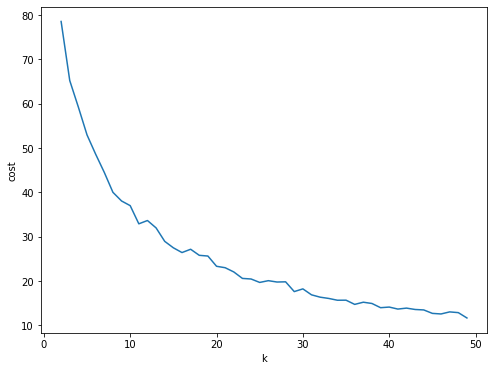

In [93]:
## plot cost for each k
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,50),cost[2:50])
ax.set_xlabel('k')
ax.set_ylabel('cost')

#### Creating k-means model based on calculated k

In [94]:
## make k-means clustering model with k based on previous calculations
## in that case we chosed k = 30 
## because before 40 we can see a clear increase of cost, but after 40 the cost stabilizes and then only a slight decrease occurs.
k = 30 
## clustering is performed based on the values from the newly created column 'features' containing all the features
## creating clusterisation model with k = 30 clusters
kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
## fit the model to all data
model = kmeans.fit(df_kmeans)
centers = model.clusterCenters()

print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[8.08008682e-02 4.44727893e-01 4.41701457e-02 5.61714279e-01
 1.27571428e-01 2.76642859e-01 6.31868133e-02 1.42084941e-01
 7.85189076e-02 4.55281266e-03 2.16712892e-04 3.00311527e-01]
[0.58585858 0.98015873 0.69349148 0.35133333 0.044      0.60433333
 0.65064102 0.         0.         0.07963488 0.89178803 0.93904465]
[0.06141414 0.43849207 0.01531837 0.12725    0.44291667 0.40116667
 0.13141026 0.03828829 0.03094363 0.00291155 0.         0.37985462]
[0.25000001 0.73809522 0.11195821 0.11283333 0.04633333 0.83208333
 0.85576923 0.00382883 0.02558211 0.0998977  0.02331108 0.69561266]
[0.43939395 0.74404761 0.49364677 0.4395     0.0935     0.46300001
 0.00480769 0.00135135 0.00643382 0.46175638 0.11195388 0.70280376]
[0.01       0.01690476 0.01       0.         1.         0.01
 0.63942307 0.0027027  0.         0.         0.         0.02057632]
[0.80808081 0.75793652 0.77311875 0.34933333 0.06       0.59000001
 0.59294871 0.03153153 0.07169117 0.73685867 0.13046116 0.6937

#### Fitting the predictions to all data

In [95]:
transformed = model.transform(df_kmeans).select('ID', 'prediction')
rows = transformed.collect()
print(rows[:3])

[Row(ID=0.0, prediction=11), Row(ID=0.003787878787878788, prediction=11), Row(ID=0.007575757575757576, prediction=11)]


In [96]:
df_pred = sqlContext.createDataFrame(rows)
df_pred.show()

+--------------------+----------+
|                  ID|prediction|
+--------------------+----------+
|                 0.0|        11|
|0.003787878787878788|        11|
|0.007575757575757576|        11|
|0.011363636363636364|        28|
|0.015151515151515152|        11|
| 0.01893939393939394|        14|
|0.022727272727272728|        11|
|0.026515151515151516|        11|
|0.030303030303030304|        11|
| 0.03409090909090909|        11|
| 0.03787878787878788|        11|
| 0.04166666666666667|        11|
|0.045454545454545456|        29|
| 0.04924242424242424|        29|
| 0.05303030303030303|        29|
| 0.05681818181818182|        29|
| 0.06060606060606061|        11|
| 0.06439393939393939|        29|
| 0.06818181818181818|        29|
| 0.07196969696969698|        28|
+--------------------+----------+
only showing top 20 rows



In [97]:
## join predictions with all data frame
df_pred = df_pred.join(allData, 'ID')
df_pred.show()
pddf_pred = df_pred.toPandas().set_index('ID')
pddf_pred

+-------------------+----------+-----------+----------+-----------+-----+-----+-----+-----------+------------+------------+------------+------------+----------+
|                 ID|prediction|      Years|       MAX|  RoutesNbr|   OS|Flash|   RP|     Region|         <6a|      6a-6c+|      7a-7c+|        =>8a|     Grade|
+-------------------+----------+-----------+----------+-----------+-----+-----+-----+-----------+------------+------------+------------+------------+----------+
| 0.6098484848484849|        10|       0.01|0.23809524|       0.01|  0.0|  0.0| 0.01|  0.5192308|0.0027027028|         0.0|         0.0|         0.0|0.31152648|
| 0.5757575757575758|        17|       0.01|0.26190478|       0.01|  0.0|  0.0|  1.0|      0.625|         0.0|0.0018382353|         0.0|         0.0| 0.3426791|
| 0.9280303030303031|         6|        1.0|      0.75|  0.6497247|0.325|0.036|0.638|  0.5576923|         0.0|         0.0|   0.6803588| 0.057038836|0.68380064|
| 0.1856060606060606|        22|  

,prediction,Years,MAX,RoutesNbr,OS,Flash,RP,Region,<6a,6a-6c+,7a-7c+,=>8a,Grade
ID,,,,,,,,,,,,,
0.609848,10,0.010000,0.238095,0.010000,0.000,0.000,0.010,0.519231,0.002703,0.000000,0.000000,0.000000,0.311526
0.575758,17,0.010000,0.261905,0.010000,0.000,0.000,1.000,0.625000,0.000000,0.001838,0.000000,0.000000,0.342679
0.928030,6,1.000000,0.750000,0.649725,0.325,0.036,0.638,0.557692,0.000000,0.000000,0.680359,0.057039,0.683801
0.185606,22,0.010000,0.250000,0.001271,0.000,0.000,0.750,0.009615,0.010811,0.000000,0.000000,0.000000,0.174455
0.416667,18,0.090909,0.714286,0.143583,0.116,0.191,0.690,0.432692,0.005405,0.218750,0.102455,0.001214,0.539564
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.973485,18,0.121212,0.714286,0.079627,0.223,0.203,0.573,0.557692,0.035135,0.132353,0.047686,0.001820,0.472274
0.151515,0,0.030303,0.511905,0.022872,0.399,0.200,0.381,0.028846,0.005405,0.047794,0.012748,0.000000,0.490654
0.780303,20,0.424242,0.738095,0.160102,0.235,0.087,0.678,0.576923,0.000000,0.011029,0.150614,0.032767,0.708100


In [98]:
pddf_pred.to_csv(('/content/drive/MyDrive/DM_CLIMBING/all_predicted.csv'))

##### Checking dataframe and marging predicted data with data before normalization

In [99]:
pddf_pred = pd.read_csv('/content/drive/MyDrive/DM_CLIMBING/all_predicted_nonorm.csv')

#### Calculating features variance

In [108]:
## calculate which features have biggest variation
stats=pd.DataFrame()
stats["Var"]=pddf_pred.var()
stats.sort_values('Var')

,Var
Flash,0.026755
OS,0.036604
RP,0.063985
Grade,0.517042
MAX,0.846538
Years,33.616266
Prediction,75.976758
Region,1083.602687
<6a,1184.837107
6a-6c+,4017.675815


In [104]:
pddf_pred_grouped = pddf_pred.groupby('Prediction').agg({'Years':'mean',	'MAX':'mean',	'RoutesNbr':'mean','OS':'mean',	'Flash':'mean','RP':'mean',	'Region': (lambda x:x.value_counts().index[0]),	'<6a':'mean', '6a-6c+': 'mean',	'7a-7c+':'mean',	'=>8a':'mean',	'Grade':'mean'})

In [125]:
regions_dict2 = dict(zip(regions_dict.values(), regions_dict.keys()))

In [ ]:
regions_dict2

In [145]:

pddf_pred_grouped = pddf_pred_grouped.replace({'Region': regions_dict2})

In [151]:
pddf_pred_grouped.to_csv('/content/drive/MyDrive/DM_CLIMBING/all_predicted_trans.csv')

In [153]:
pddf_pred_grouped

,Prediction,Years,MAX,RoutesNbr,OS,Flash,RP,Region,<6a,6a-6c+,7a-7c+,=>8a,Grade
0,0,3.642857,6.867857,105.285714,0.561714,0.127571,0.275929,Kalymnos,52.571429,42.714286,9.642857,0.357143,5.964000
1,1,20.333333,9.116667,1638.333333,0.351333,0.044000,0.604333,Sogn,0.000000,0.000000,168.666667,1469.666667,8.014333
2,2,2.916667,6.841667,37.166667,0.127250,0.442917,0.401167,Frankenjura,14.166667,16.833333,6.166667,0.000000,6.219333
3,3,9.250000,8.100000,265.333333,0.112833,0.046333,0.832083,RMNP (CO),1.416667,13.916667,211.583333,38.416667,7.232917
4,4,15.500000,8.125000,1166.500000,0.439500,0.093500,0.463000,Kalymnos,0.500000,3.500000,978.000000,184.500000,7.256000
5,5,1.000000,5.050000,1.000000,0.000000,1.000000,0.000000,Siurana,1.000000,0.000000,0.000000,0.000000,5.050000
6,6,27.666667,8.183333,1826.333333,0.349333,0.060000,0.590000,Split,11.666667,39.000000,1560.666667,215.000000,7.227000
7,7,16.333333,8.050000,875.000000,0.424000,0.074000,0.470333,RMNP (CO),24.000000,186.000000,639.666667,25.333333,6.753000
8,8,5.500000,8.525000,89.583333,0.067167,0.069917,0.862583,Sinks Canyon (WY),0.416667,2.083333,31.250000,55.833333,7.820750
9,9,5.473684,7.957895,134.315789,0.322263,0.060368,0.605684,Innsbruck,2.473684,17.052632,104.894737,9.894737,7.081789


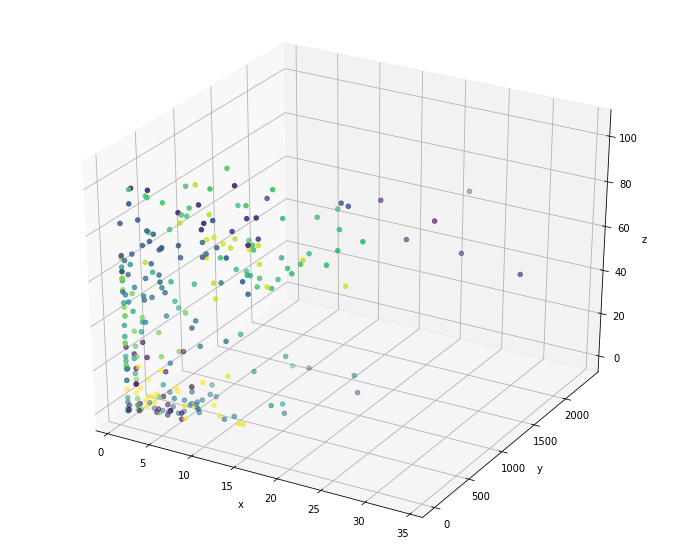

In [110]:
plot_y_g_m = plt.figure(figsize=(12,10)).gca(projection='3d')
plot_y_g_m.scatter( pddf_pred.Years,pddf_pred.RoutesNbr, pddf_pred.Region, c=pddf_pred.Prediction)
plot_y_g_m.set_xlabel('x')
plot_y_g_m.set_ylabel('y')
plot_y_g_m.set_zlabel('z')
plt.show()

**Such a large number of clusters was selected due to the large number of climbing regions**
